<font size = "5"> **[Image Tools](2_Image_Tools.ipynb)** </font>

<hr style="height:2px;border-top:4px solid #FF8200" />


# Adaptive Fourier Filtering


part of 

<font size = "4"> **pyTEMlib**, a **pycroscopy** library </font>


Notebook by 

Gerd Duscher

Materials Science & Engineering<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville


An introduction into Fourier Filtering of images.


## Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install git+https://github.com/pycroscopy/pyTEMlib/ -q

# pyTEMlib setup ------------------
else:
    if test_package('sidpy') < '0.0.11':
        print('installing sidpy')
        !{sys.executable} -m pip install  --upgrade sidpy -q     
    if test_package('pyNSID') < '0.0.5':
        print('installing pyNSID')
        !{sys.executable} -m pip install  --upgrade pyNSID -q 
    if test_package('pyTEMlib') < '0.2022.12.0':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

installing pyTEMlib
done


## Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets. 



In [14]:
%matplotlib  notebook

import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.insert(0,'../../')

import pyTEMlib
import pyTEMlib.file_tools as ft
import pyTEMlib.image_tools as it

print('pyTEMlib version: ', pyTEMlib.__version__)
note_book_version = '2021.10.25'
note_book_name='pyTEMib/notebooks/Imaging/Adaptive_Fourier_Filter'

SimpleITK not installed; Registration Functions for Image Stacks not available
install with: conda install -c simpleitk simpleitk 
pyTEMlib version:  0.2022.12.0


## Open File

These datasets are stored in the pyNSID data format (extension: hf5) automatically. 

All results can be stored in that file. 

First we select the file

In [6]:
file_widget = ft.FileWidget('.')

Select(description='Select file:', layout=Layout(width='70%'), options=('.',), rows=10, value='.')

directory moved since last time read


Now, we open and plot them

<IPython.core.display.Javascript object>


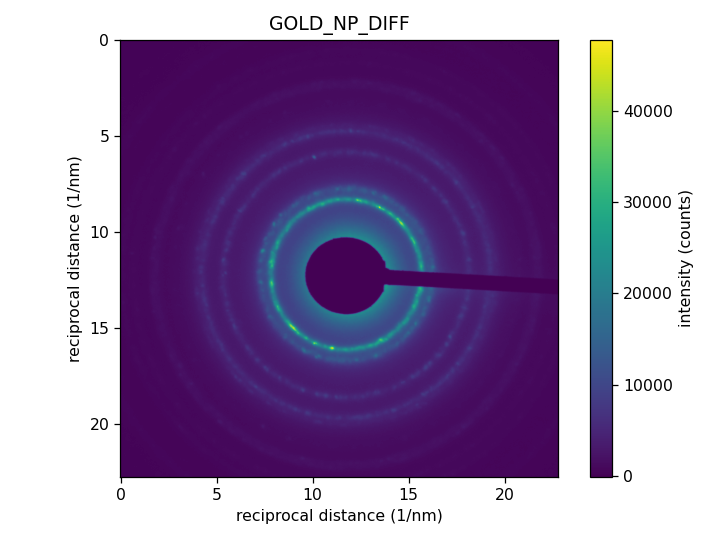

In [11]:
file_name = file_widget.file_name

datasets = ft.open_file(file_name)
dataset = datasets['Channel_000']
if dataset.data_type.name != 'IMAGE':
    print('We really would need an image here')

view = dataset.plot()

## Power Spectrum of Image

fft :
	smoothing : 1
	minimum_intensity : 11.934666600006025
	maximum_intensity : 19.643160820417574
source:  SciFiReaders.DMReader


<IPython.core.display.Javascript object>


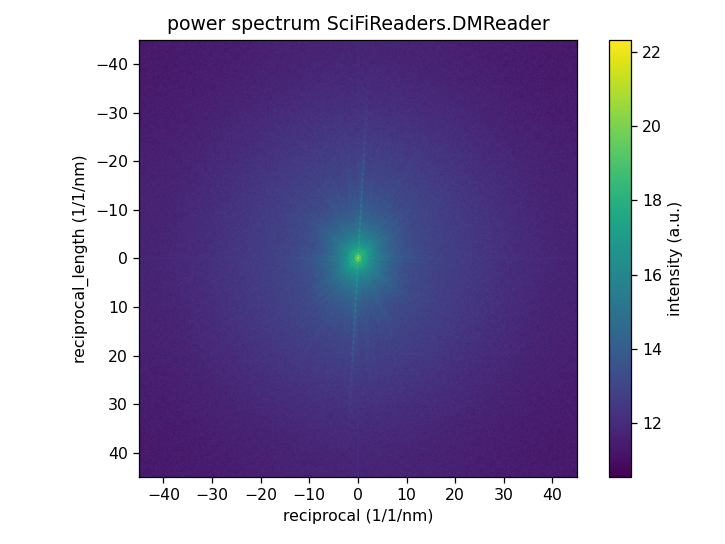

In [16]:
power_spectrum = it.power_spectrum(dataset, smoothing=1)

power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
view = power_spectrum.plot()

## Spot Detection in Fourier Transform

Found 0 reflections


<IPython.core.display.Javascript object>


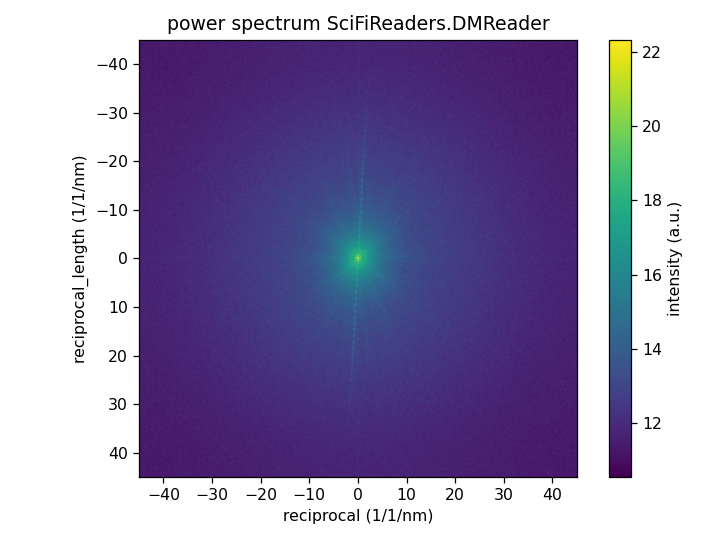

In [17]:
# ------Input----------
spot_threshold=0.12
# ---------------------

spots = it.diffractogram_spots(power_spectrum, spot_threshold=spot_threshold)
spots = spots[np.linalg.norm(spots[:,:2],axis=1)<8,:]
spots = spots[np.linalg.norm(spots[:,:2],axis=1)>0.5,:]
power_spectrum.plot()

plt.gca().scatter(spots[:,0],spots[:,1], color='red', alpha=0.4);

## Adaptive Fourier Filter

In [19]:
filtered_dataset = it.adaptive_fourier_filter(dataset, spots, low_pass=2., reflection_radius=.3)
view = filtered_dataset.plot()

IndexError: list index out of range

Let's see what we did - In Fourier space, of course.

<IPython.core.display.Javascript object>


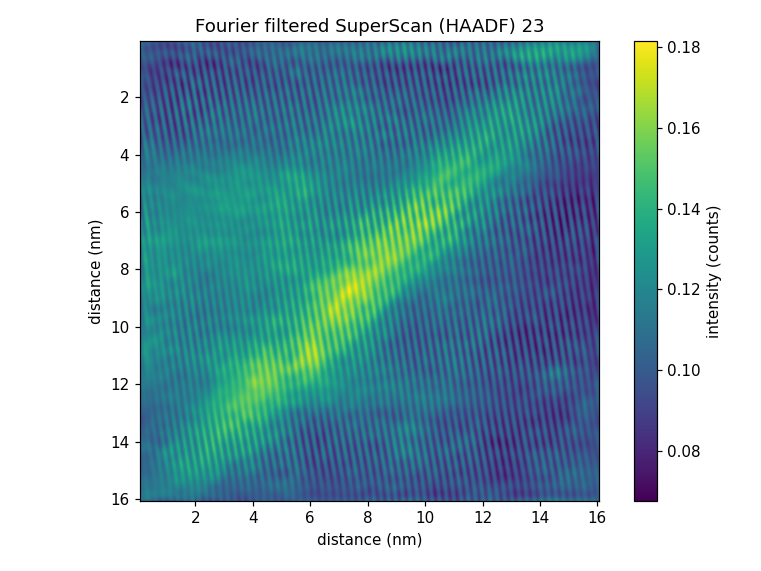

In [39]:
filtered_dataset.view.fig

In [ ]:
filtered_power_spectrum = it.power_spectrum(filtered_dataset, smoothing=0)

power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
filtered_power_spectrum.plot()

Please note that the spots are ordered from center to outside.

The third parameter of a spot is its angle.

In [ ]:
print(spots[:5])

## Log the result

In [ ]:
results_channel = ft.log_results(dataset.h5_dataset.parent.parent, filtered_dataset)


A tree-like plot of the file

In [ ]:
ft.h5_tree(dataset.h5_dataset.file)

In [ ]:
dataset.h5_dataset.parent

A convenient function to select a dataset (for further processing, visualization or whatever)

In [ ]:
choose_image = ft.ChooseDataset(dataset.h5_dataset.parent.parent)

The selected dataset can then easily be plotted

In [ ]:
choose_image.dataset.plot()

## Close File
let's close the file but keep the filename

In [ ]:
filename = results_channel.file.filename
results_channel.file.close()

## Simulate new notebook
We can now simulate a new notebook and open the file again.



In [ ]:
new_dataset= ft.open_file(filename)
choose_image = ft.ChooseDataset(new_dataset.h5_dataset.parent)

In [ ]:
choose_image.dataset.plot()

We want to make an image operation of the images in the file.

In [ ]:
choose_image = ft.ChooseDataset(new_dataset.h5_dataset.parent.parent)
print('       subtract')
choose_image2 = ft.ChooseDataset(new_dataset.h5_dataset.parent)

In [ ]:
new_image = np.array(choose_image.dataset) - np.array(choose_image2.dataset)
new_image = new_dataset.like_data(new_image)
new_image.plot()

## Close File for Good

In [ ]:
new_dataset.h5_dataset.file.close()